In [62]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
from PIL import Image
import numpy as np
from torchvision.datasets import ImageFolder
from transformers import ViTConfig, ViTForImageClassification
from sklearn.metrics import accuracy_score, confusion_matrix
import gc
import pandas as pd

In [63]:
augment_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomHorizontalFlip(1.0),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2), antialias=True),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
    transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [85]:
path = "Dataset"
train_dataset = ImageFolder(path+"/train", transform=transform)
augment_dataset = ImageFolder(path+"/train", transform=augment_transform)
train_dataset = ConcatDataset([train_dataset, augment_dataset])
test_dataset = ImageFolder(path+"/test", transform=transform)

In [65]:
print(len(train_dataset))
print(len(test_dataset))

57418
7178


In [66]:
training_ratio = 0.9
n_train_examples = int(len(train_dataset) * training_ratio)
n_valid_examples = len(train_dataset) - n_train_examples
train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform

In [67]:
def collate_function(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image)
        labels.append(label)

    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

Batch_Size = 64
train_loader = DataLoader(train_dataset, collate_fn=collate_function, batch_size=Batch_Size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, collate_fn=collate_function, batch_size=Batch_Size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, collate_fn=collate_function, batch_size=Batch_Size, shuffle=False, num_workers=0)

In [68]:
def print_data(loader):
    for i, batch in enumerate(loader):
        print(f"Batch {i+1}:")
        print("Pixel values:")
        print(batch["pixel_values"])
        print("Labels:")
        print(batch["labels"])
        break

print("Train loader:")
print_data(train_loader)

print("Valid loader:")
print_data(valid_loader)

print("Test loader:")
print_data(test_loader)


Train loader:
Batch 1:
Pixel values:
tensor([[[[-0.5621, -0.5797, -0.6070,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6111, -0.6292, -0.6558,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6853, -0.7017, -0.7247,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.5621, -0.5797, -0.6070,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6111, -0.6292, -0.6558,  ..., -1.0000, -1.0000, -1.0000],
          [-0.6853, -0.7017, -0.7247,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.5621, -0.5797, -0.6070,  ..., -1.0000, -1.0000, -1.

In [69]:
device = torch.device("cuda")

In [70]:
torch.cuda.empty_cache()
gc.collect()

54

In [71]:
configuration = ViTConfig()
configuration.num_labels = 7
configuration.return_dict = False

In [72]:
model = ViTForImageClassification(configuration).from_pretrained('google/vit-base-patch16-224')
model.num_labels = 7
model.name = 'Vision Transformer'
model.classifier = nn.Linear(configuration.hidden_size, configuration.num_labels)
vit = model.to(device)

for param in vit.vit.parameters():
    param.requires_grad = False
for param in vit.classifier.parameters():
    param.requires_grad = True
for param in vit.vit.encoder.layer[-1].parameters():
    param.requires_grad = True
for param in vit.vit.layernorm.parameters():
    param.requires_grad = True

In [73]:
for name, param in vit.named_parameters():
     print(name, param.requires_grad)

vit.embeddings.cls_token False
vit.embeddings.position_embeddings False
vit.embeddings.patch_embeddings.projection.weight False
vit.embeddings.patch_embeddings.projection.bias False
vit.encoder.layer.0.attention.attention.query.weight False
vit.encoder.layer.0.attention.attention.query.bias False
vit.encoder.layer.0.attention.attention.key.weight False
vit.encoder.layer.0.attention.attention.key.bias False
vit.encoder.layer.0.attention.attention.value.weight False
vit.encoder.layer.0.attention.attention.value.bias False
vit.encoder.layer.0.attention.output.dense.weight False
vit.encoder.layer.0.attention.output.dense.bias False
vit.encoder.layer.0.intermediate.dense.weight False
vit.encoder.layer.0.intermediate.dense.bias False
vit.encoder.layer.0.output.dense.weight False
vit.encoder.layer.0.output.dense.bias False
vit.encoder.layer.0.layernorm_before.weight False
vit.encoder.layer.0.layernorm_before.bias False
vit.encoder.layer.0.layernorm_after.weight False
vit.encoder.layer.0.layer

In [74]:
model_parameters = filter(lambda p: p.requires_grad, vit.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

7094791

In [75]:
In_testing = False
optimizer = optim.Adam(vit.parameters(), lr = 0.001)
num_epochs = 30
num_training_steps = num_epochs * len(train_loader)

In [76]:
def plot_confusion_matrix(cm):
    cm_df = pd.DataFrame(cm)

    plt.figure(figsize=(18,12))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')

    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score
def compute_and_plot_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.plot(metrics, values, marker='o')
    plt.ylim([0, 1])
    plt.title(f'Model Metrics')
    plt.show()

In [78]:
from tqdm import tqdm
def ViT_test(model, dataloader):
    model.eval()

    correct = 0
    total_loss = 0
    total = 0
    all_labels = []
    all_predictions = []

    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        total_loss += outputs[0]
        logits = outputs[1]
        predictions = torch.argmax(logits, dim=-1)
        total += batch['labels'].size(0)
        correct += (predictions == batch['labels']).sum().item()
        all_labels.extend(batch['labels'].cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    acc = 100 * correct / total
    total_loss = total_loss / total
    cm = confusion_matrix(all_labels, all_predictions)
    
    if In_testing == True:
        plot_confusion_matrix(cm)
        compute_and_plot_metrics(all_labels, all_predictions)

    return acc, total_loss

In [79]:
def ViT_train(model):
    model.train()

    for epoch in range(num_epochs):
        train_loss = 0
        train_correct = 0
        total = 0
        train_predictions = []
        train_labels = []
        for batch in tqdm(train_loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs[0]
            loss.backward()

            train_loss += loss.item()
            logits = outputs[1]
            predictions = torch.argmax(logits, dim=-1)
            total += batch['labels'].size(0)
            train_correct += (predictions == batch['labels']).sum().item()

            train_predictions.append(predictions.detach().cpu())
            train_labels.append(batch['labels'].detach().cpu())

            optimizer.step()
            optimizer.zero_grad()

        train_loss = train_loss / total
        train_acc = 100 * train_correct / total
        print("Epoch {}".format(epoch+1))
        print("Train loss: {}.\t Train accuracy: {:.2f}%".format(train_loss, train_acc))

        train_predictions = torch.cat(train_predictions)
        train_labels = torch.cat(train_labels)

        #compute_and_plot_metrics(train_labels, train_predictions)

        valid_acc, valid_loss = ViT_test(model, valid_loader)
        print("Valid loss: {}.\t Valid accuracy: {:.2f}%".format(valid_loss, valid_acc))

        torch.save(model, "model.pth")


In [80]:
vit = torch.load("model.pth")
ViT_train(vit)

  0%|          | 1/898 [00:07<1:50:29,  7.39s/it]


KeyboardInterrupt: 

100%|██████████| 113/113 [05:16<00:00,  2.80s/it]


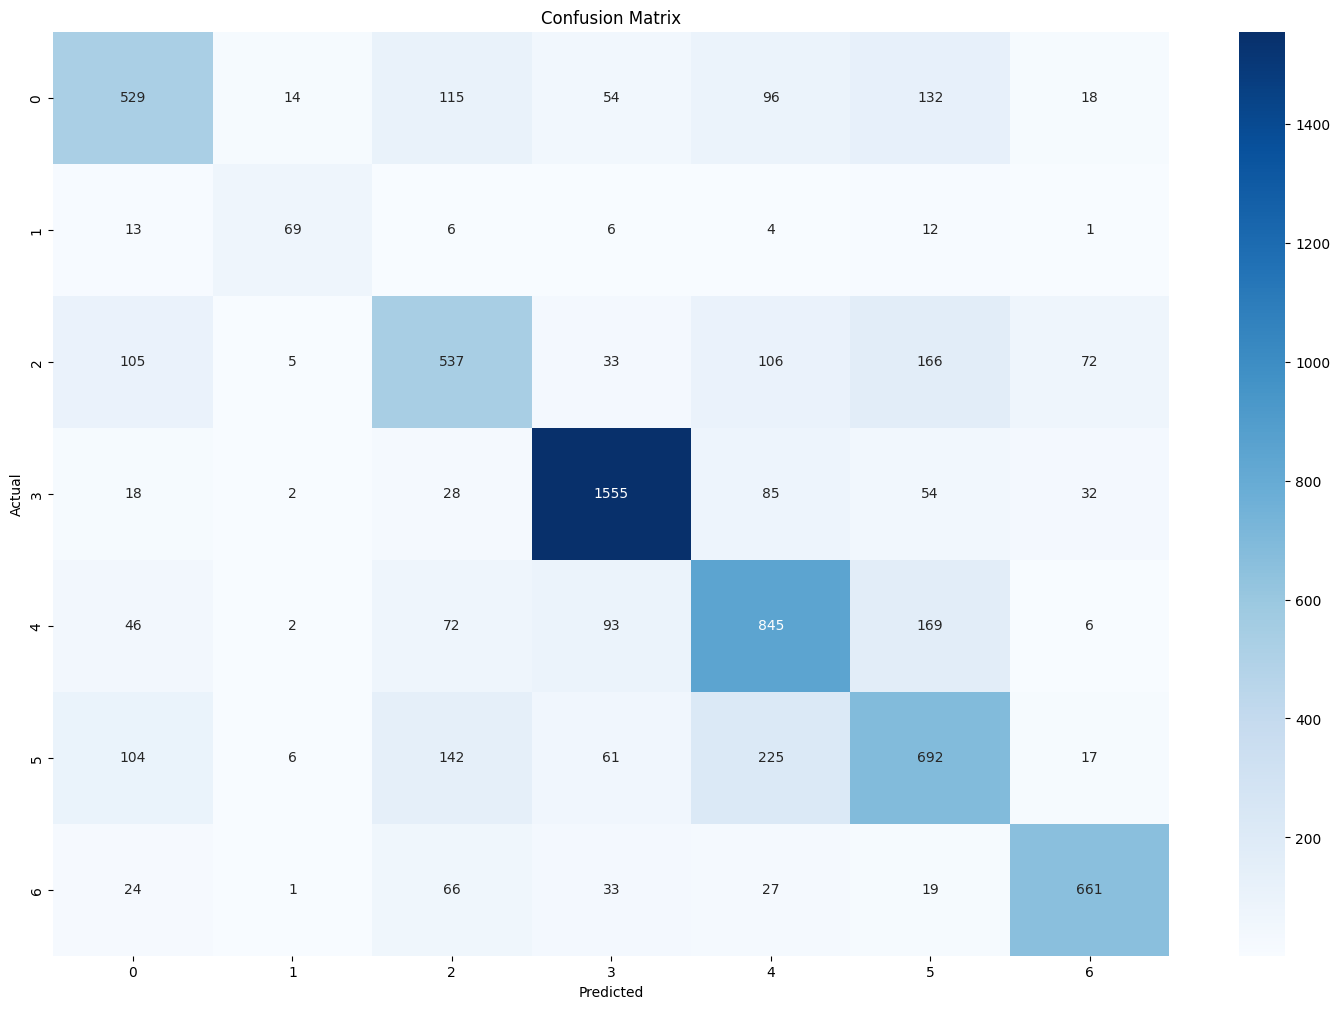

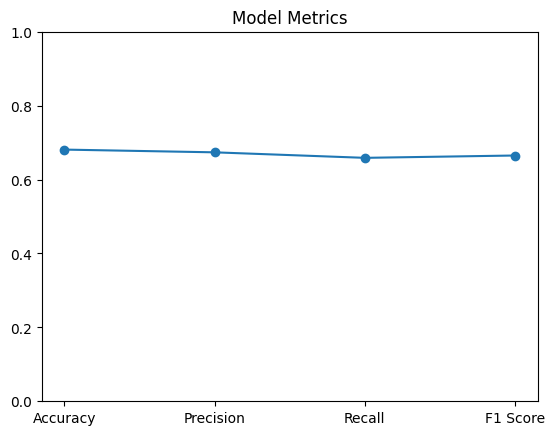

(68.09696294232377, tensor(0.0222, device='cuda:0'))

In [81]:
In_testing = True
ViT_test(vit, test_loader)

In [84]:
torch.save(vit, "model.pth")